In [1]:
import os
import torch
import transformers
import torchist

import neuzips

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


def load_model(model_path):
    return transformers.AutoModelForCausalLM.from_pretrained(
        model_path, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16
    )


def load_tokenizer(tokenizer_path):
    return transformers.AutoTokenizer.from_pretrained(tokenizer_path)


model_id = "meta-llama/Meta-Llama-3-8B"
# model_id = "google/gemma-2b"

manager = neuzips.Manager(precision=7, normalizer_size=512)

model = load_model(model_id)
tokenizer = load_tokenizer(model_id)

/mnt/nvme/yongchang/miniforge3/envs/cuda121/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 11.31it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def entropy_fn(p):
    return -torch.sum(p * torch.where(torch.isfinite(torch.log2(p)), torch.log2(p), 0))


def plot_histogram(sign, exp, frac):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, arr in enumerate([sign, exp, frac]):
        low_lim = 0 if i == 0 else -127 if i == 1 else 0
        high_lim = 1 if i == 0 else 127 if i == 1 else 127
        hist = torchist.histogram(arr.reshape(-1), bins=high_lim - low_lim + 1, low=low_lim, upp=high_lim)
        hist = hist / hist.sum()
        entropy = entropy_fn(hist)
        hist = hist.cpu().numpy()
        bins = np.arange(low_lim, high_lim + 1)
        axes[i].bar(bins, hist, width=1.0)
        name = "Sign" if i == 0 else "Exp" if i == 1 else "Frac"

        title = f"{name} Entropy: {entropy:.2f}"
        axes[i].set_title(title)

    plt.show()


def plot_tensor(tensor):
    exp, frac = manager.split(tensor)
    exp = exp.int() - 127
    frac = frac.int()
    sign = torch.zeros_like(exp)
    sign[frac >= 128] = 1
    sign[frac < 128] = 0

    frac = torch.where(frac >= 128, frac - 128, frac)
    number = (2.0**exp) * (1.0 + frac / 128.0) * sign
    number = number.to(tensor)
    print(torch.allclose(number, tensor, atol=0, rtol=0))

    plot_histogram(sign, exp, frac)


def plot_model(model):
    import matplotlib.pyplot as plt
    import numpy as np

    sign_hist = torch.zeros(2, dtype=torch.int64).cuda()
    exp_hist = torch.zeros(256, dtype=torch.int64).cuda()
    frac_hist = torch.zeros(128, dtype=torch.int64).cuda()
    with torch.no_grad():
        for param in model.parameters():
            exp, frac = manager.split(param)
            exp = exp.int() 
            frac = frac.int()
            sign = torch.zeros_like(exp)
            sign[frac >= 128] = 1
            sign[frac < 128] = 0
            frac = torch.where(frac >= 128, frac - 128, frac)

            sign_hist += torchist.histogram(sign.reshape(-1), bins=2, low=0, upp=1)
            exp_hist += torchist.histogram(exp.reshape(-1), bins=256, low=0, upp=255)
            frac_hist += torchist.histogram(frac.reshape(-1), bins=128, low=0, upp=127)

    # high DPI
    plt.rcParams['figure.dpi'] = 300
    # tight layout
    plt.rcParams['figure.autolayout'] = True
    fig, axes = plt.subplots(1, 3, figsize=(11, 3.25))

    for i, hist in enumerate([sign_hist, exp_hist, frac_hist]):
        hist = hist / hist.sum()
        entropy = entropy_fn(hist)
        hist = hist.cpu().numpy()
        bins = np.arange(hist.size)
        axes[i].bar(bins, hist, width=1, color='#85B4DF')
        name = "Sign" if i == 0 else "Exponent" if i == 1 else "Mantissa"

        if name == "Sign":
            axes[i].set_xticks([0, 1])
            maximum = 1
        elif name == "Exponent":
            sticks = np.arange(0, 257, 64)
            sticks[-1] = 255
            axes[i].set_xticks(sticks)
            maximum = 8
        else:
            sticks = np.arange(0, 129, 32)
            sticks[-1] = 127
            axes[i].set_xticks(sticks)
            maximum = 7

        title = f"{name}: entropy= {entropy:.2f} with {maximum} bits"
        axes[i].set_title(title)
        # axes[i].set_xlim([0 - 0.5, hist.size - 0.5])

    plt.show()

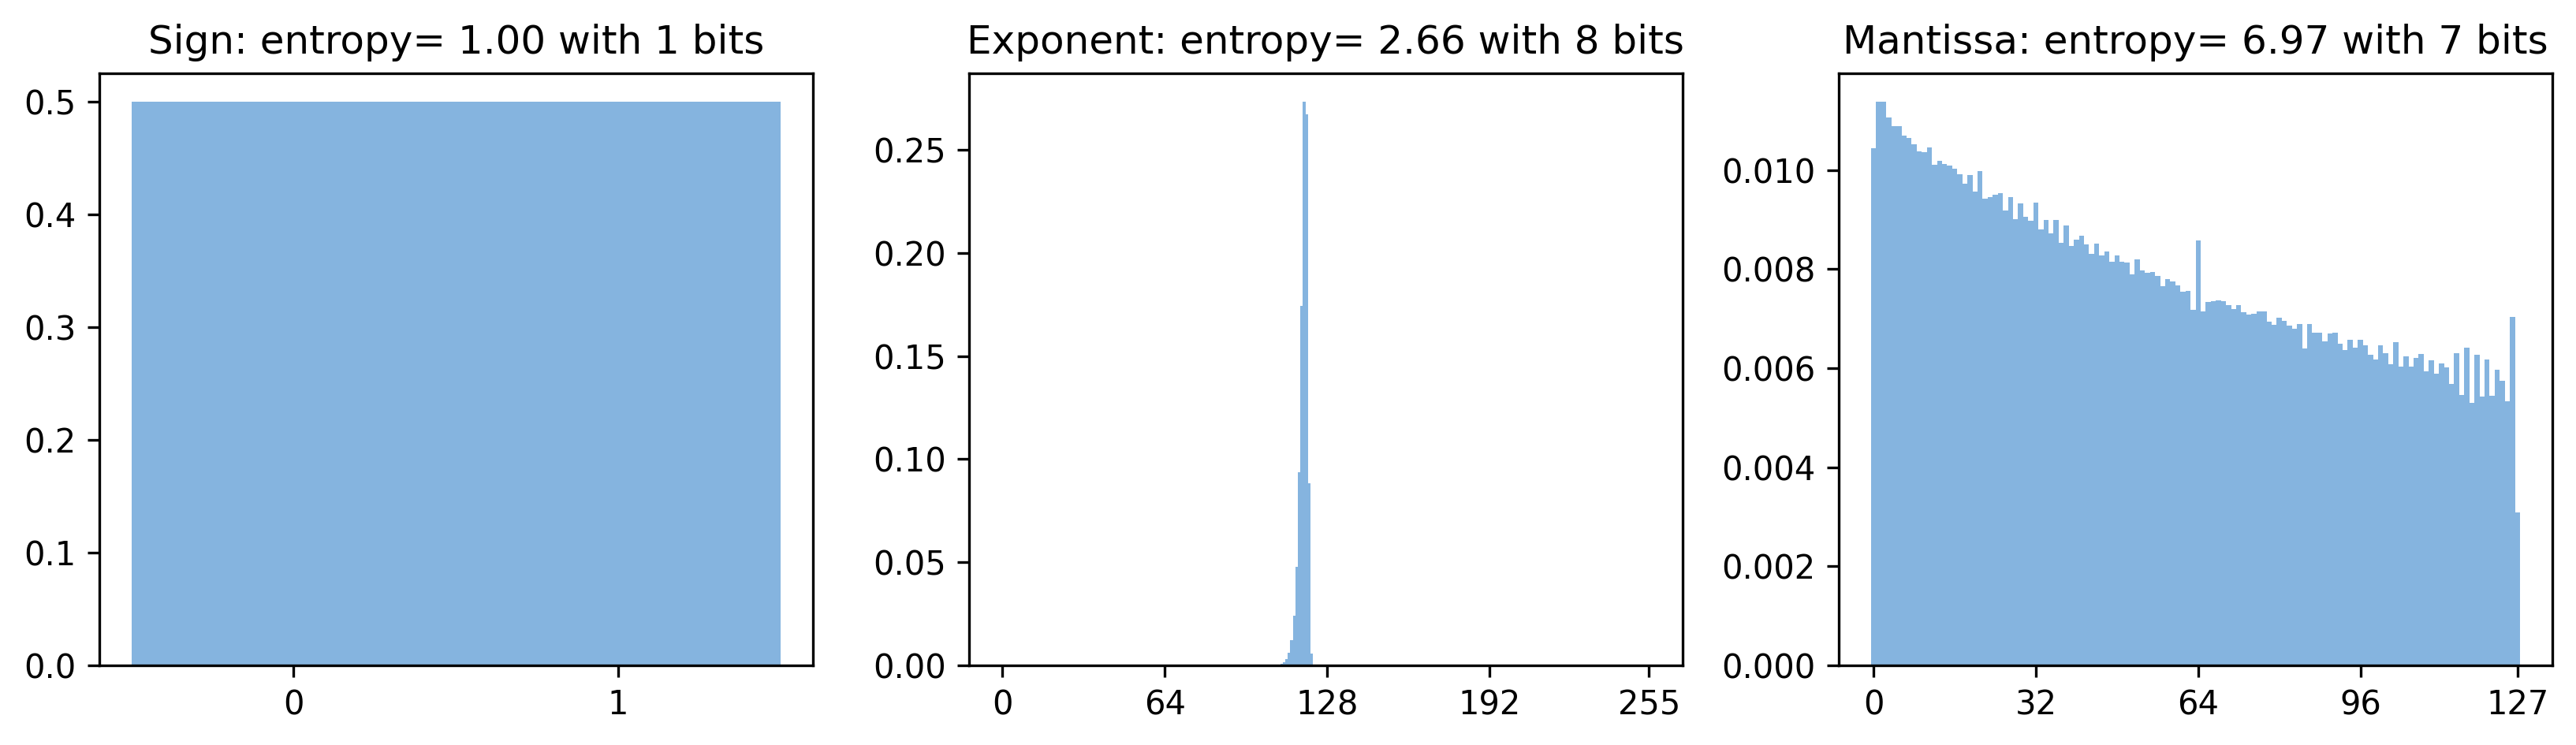

In [9]:
plot_model(model)

In [16]:
print(number[err_mask][0].item(), p[err_mask][0].item())

0.0 -0.00390625


False


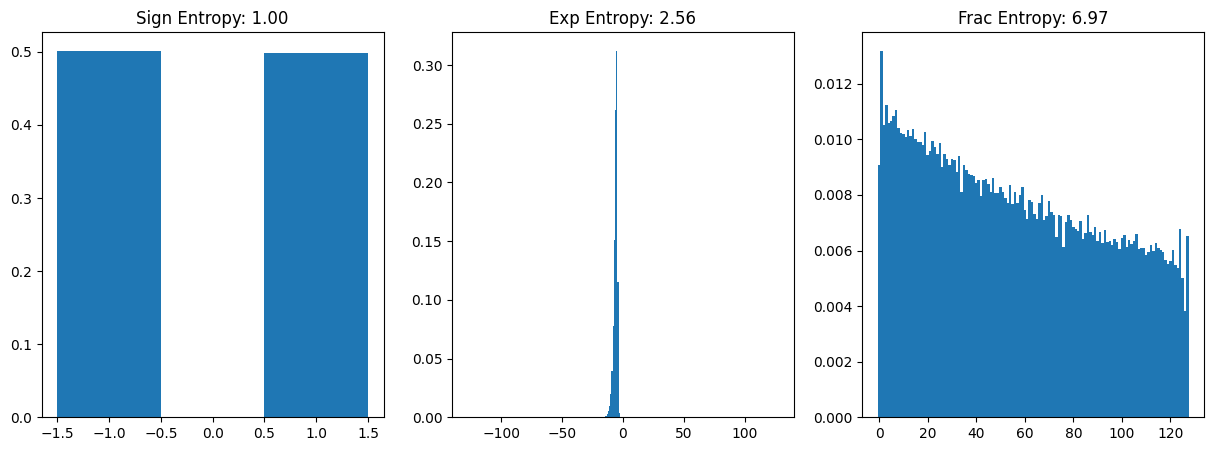

In [5]:
random_gaussian = torch.randn(512 * 512, dtype=torch.bfloat16, device="cuda") * ((2 / 512) ** 0.5)

plot(random_gaussian)